# Importing the Natural Language Toolkit

In [1]:
import nltk #natural language tool kit
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [2]:
nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.corpus import gutenberg
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [2]:
data = ""
files = ['austen-emma.txt','austen-persuasion.txt']
for file_id in files:
    data += gutenberg.raw(file_id) + " "

In [44]:
data = gutenberg.raw('austen-emma.txt')

In [45]:
print("Length", len(data))
print("Preview:\n", data[:500])

Length 887071
Preview:
 [Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


# Data Refining

In [46]:
data = data.lower()

In [47]:
import re
data = re.sub(r'\d+', '', data)  # removing digits
data = re.sub(r'\s+', ' ', data).strip() #removing extra spaces

In [48]:
#tokenization
from nltk.tokenize import word_tokenize
tokens = word_tokenize(data)

In [49]:
print(f"Total tokens: {len(tokens)}")
print("Sample tokens:", tokens[:50])

Total tokens: 191850
Sample tokens: ['[', 'emma', 'by', 'jane', 'austen', ']', 'volume', 'i', 'chapter', 'i', 'emma', 'woodhouse', ',', 'handsome', ',', 'clever', ',', 'and', 'rich', ',', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', ',', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', ';', 'and', 'had', 'lived', 'nearly', 'twenty-one', 'years', 'in', 'the', 'world', 'with', 'very']


In [50]:
from collections import Counter

In [21]:
pip install torch

   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB 5.7 MB/s eta 0:00:39
   ---------------------------------------- 0.7/216.1 MB 6.9 MB/s eta 0:00:32
   ---------------------------------------- 1.0/216.1 MB 7.0 MB/s eta 0:00:31
   ---------------------------------------- 1.4/216.1 MB 7.6 MB/s eta 0:00:29
   ---------------------------------------- 1.8/216.1 MB 7.6 MB/s eta 0:00:29
   ---------------------------------------- 2.2/216.1 MB 7.2 MB/s eta 0:00:30
   ---------------------------------------- 2.4/216.1 MB 6.9 MB/s eta 0:00:31
    --------------------------------------- 2.8/216.1 MB 7.1 MB/s eta 0:00:30
    --------------------------------------- 3.1/216.1 MB 7.1 MB/s eta 0:00:31
    --------------------------------------- 3.5/216.1 MB 6.9 MB/s eta 0:00:31
    --------------------------------------- 3.7/216.1 MB 6.7 MB/s eta 0:00:32
    --------------------------------------- 4.0/216.1 MB 6.7 MB/s eta 0

In [51]:
from torch.utils.data import Dataset
import torch

In [ ]:
pip install --upgrade typing_extensions

In [52]:
word_counts = Counter(tokens) #dictionarys for word count using counter

In [53]:
#sorting the vocab
sorted_words = sorted(word_counts,key=word_counts.get,reverse=True)
word2idx = {word: idx+1 for idx, word in enumerate(sorted_words)}  # +1 to reserve 0 for padding
idx2word = {idx: word for word, idx in word2idx.items()}

In [54]:
#converting words to indices
token_ids = [word2idx[word] for word in tokens]

In [55]:
sequence_length = 5 #here 6th word would be the output
sequences = []
for i in range(sequence_length, len(token_ids)):
    seq = token_ids[i-sequence_length:i]
    label = token_ids[i]
    sequences.append((seq, label)) #building the sequences

print("Sample input sequence:", sequences[0])

Sample input sequence: ([3378, 37, 52, 100, 4515], 3379)


# Using Datloader and Dataset for Pytorch ingestion

In [56]:
#loading it into pytorch dataset & loader
from torch.utils.data import Dataset, DataLoader
class NextWordDataset(Dataset):
    def __init__(self, sequences):
        self.inputs = [torch.tensor(seq[0], dtype=torch.long) for seq in sequences] # every 5 words as input
        self.labels = [torch.tensor(seq[1], dtype=torch.long) for seq in sequences] #every 6th word at the label or the next word

    def __len__(self):
        return len(self.inputs) # returning the length

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx] #returning the word/label at index 

In [57]:
df = NextWordDataset(sequences) #injecting the sequences to the blue print class to predict Nextword to dataset

In [66]:
batch_size = 64
dataloader = DataLoader(df, batch_size=batch_size, shuffle=True) 
#using data loader for better model building as the data as the loader releases the data in batches of 8

In [67]:
#printing a sample batch
for X, y in dataloader:
    print("Input shape:", X.shape)
    print("Label shape:", y.shape)  
    break

Input shape: torch.Size([64, 5])
Label shape: torch.Size([64])


In [68]:
import torch.nn as nn

class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(NextWordPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) #converting palin text to vectors via embedding
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True) #using LSTM model so that the word patterns are remembered and predicted at its best
        self.fc = nn.Linear(hidden_dim, vocab_size) #wrapping the neural network model 

    def forward(self, x):
        embedded = self.embedding(x)       #embedding    
        lstm_out, _ = self.lstm(embedded)    #lstm application 
        last_output = lstm_out[:, -1, :]     # extracting the label
        out = self.fc(last_output)    #fully connected output         
        return out


In [69]:
vocab_size = len(word2idx) + 1  # +1 for padding
embed_dim = 128 #embedding dimension
hidden_dim = 256 #hidden dimension

model = NextWordPredictor(vocab_size, embed_dim, hidden_dim)


In [70]:
criterion = nn.CrossEntropyLoss() #using cross entropy 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #using Adam as optimizer function


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [72]:
model = model.to(device) #using cpu as cuba is unavailable

# Training the model

In [74]:
num_epochs = 20   #running it over 10 epochs for better accuracy
loss_values     = []          # storing loss per epoch for plotting
accuracy_values = []          # storing accuracy per epoch
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct    = 0            
    total      = 0    
    for batch_inputs, batch_labels in dataloader:
        batch_inputs = batch_inputs.to(device) #sending data & labels as batches for cpu to run
        batch_labels = batch_labels.to(device)
        outputs = model(batch_inputs)  # extracting output after feeding the input
        loss = criterion(outputs, batch_labels) #calculating loss batch wise
        optimizer.zero_grad() #applying adam's optimizer batch wise
        loss.backward() #applying backward propogation with loss
        optimizer.step()
        total_loss += loss.item() 
        preds = torch.argmax(outputs, dim=1)       #predicting most probable output
        correct += (preds == batch_labels).sum().item() #no of correct predictions
        total   += batch_labels.size(0)
    avg_loss = total_loss / len(dataloader) #evaluating tot loss per batch
    loss_values.append(avg_loss)  
    epoch_acc  = 100 * correct / total #appoch accuracy
    accuracy_values.append(epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.4f}  Accuracy: {epoch_acc:.2f}%")


Epoch [1/20]  Loss: 3.3856  Accuracy: 27.98%
Epoch [2/20]  Loss: 3.0892  Accuracy: 32.08%
Epoch [3/20]  Loss: 2.8140  Accuracy: 36.48%
Epoch [4/20]  Loss: 2.5618  Accuracy: 41.20%
Epoch [5/20]  Loss: 2.3298  Accuracy: 45.68%
Epoch [6/20]  Loss: 2.1174  Accuracy: 50.18%
Epoch [7/20]  Loss: 1.9241  Accuracy: 54.36%
Epoch [8/20]  Loss: 1.7485  Accuracy: 58.41%
Epoch [9/20]  Loss: 1.5912  Accuracy: 61.81%
Epoch [10/20]  Loss: 1.4480  Accuracy: 65.31%
Epoch [11/20]  Loss: 1.3195  Accuracy: 68.24%
Epoch [12/20]  Loss: 1.2060  Accuracy: 70.88%
Epoch [13/20]  Loss: 1.1034  Accuracy: 73.33%
Epoch [14/20]  Loss: 1.0131  Accuracy: 75.50%
Epoch [15/20]  Loss: 0.9320  Accuracy: 77.40%
Epoch [16/20]  Loss: 0.8606  Accuracy: 79.05%
Epoch [17/20]  Loss: 0.7958  Accuracy: 80.67%
Epoch [18/20]  Loss: 0.7394  Accuracy: 81.98%
Epoch [19/20]  Loss: 0.6904  Accuracy: 82.98%
Epoch [20/20]  Loss: 0.6447  Accuracy: 84.19%


# Visualising model performance

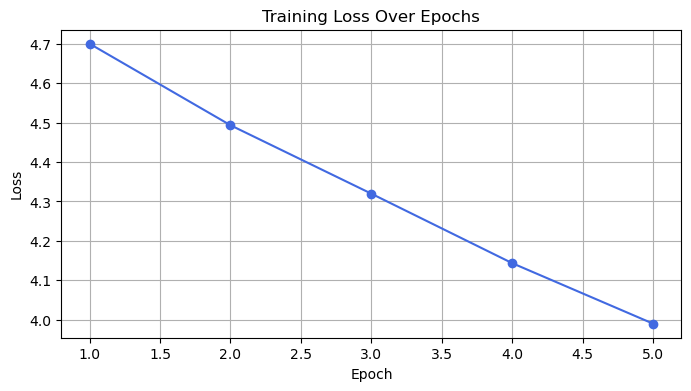

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='royalblue')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Saving and predicting the built model

In [75]:
torch.save(model.state_dict(), "next_word_model.pth")
print("Model saved as next_word_model.pth")

Model saved as next_word_model.pth


In [76]:
model = NextWordPredictor(vocab_size, embed_dim, hidden_dim)
model.load_state_dict(torch.load("next_word_model.pth"))
model.eval()
model.to(device)

NextWordPredictor(
  (embedding): Embedding(7909, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=7909, bias=True)
)

In [77]:
import torch.nn.functional as F

def predict_next_word(model, input_text, word2idx, idx2word, sequence_length=5, top_k=5):
    model.eval()

    # Cleaning and tokenizing
    input_text = input_text.lower() #converting to lower case
    input_text = re.sub(r'[^a-z\s]', '', input_text) # cleaning the text
    tokens = input_text.split()
    
    # Taking the last sequence_length tokens
    tokens = tokens[-sequence_length:]

    # Converting words to indices
    input_ids = [word2idx.get(word, 0) for word in tokens]  # 0 for unknowns
    while len(input_ids) < sequence_length:
        input_ids = [0] + input_ids  # padding on left for fixed length

    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)  # converting to torch tensor

    with torch.no_grad():
        logits = model(input_tensor)  #feedingg the model and getting the outpuy
        probs = F.softmax(logits, dim=1) #converting to probabilities
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=1) #get top predictions

    predictions = [(idx2word.get(idx.item(), '<UNK>'), prob.item()) for idx, prob in zip(top_k_indices[0], top_k_probs[0])] #mapping indecis to words
    return predictions


In [78]:
input_prompt = "she opened the door and"
predictions = predict_next_word(model, input_prompt, word2idx, idx2word)

print(f"Next word predictions for: '{input_prompt}'")
for word, score in predictions:
    print(f"{word} (prob: {score:.4f})")


Next word predictions for: 'she opened the door and'
persuasion (prob: 0.4101)
table (prob: 0.1642)
confusion (prob: 0.1015)
quick (prob: 0.0539)
open (prob: 0.0297)
